In [61]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, classification_report
import itertools


# Configuration
DATA_DIR = "screw_dataset"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 30

# Préparation des données

## 1. Fonctions de transformation

In [ ]:
def specialized_augmentation(image):
    """
    Augmentations spécifiques pour révéler les défauts subtils
    """
    transforms = [
        # Variations de contraste pour révéler détails
        lambda img: tf.image.adjust_contrast(img, random.uniform(0.8, 1.5)),
        
        # Rotations légères pour détecter alignements inhabituels
        lambda img: rotate_image(img, random.choice([-15, -10, -5, 5, 10, 15])),
        
        # Simulations de défauts localisés
        lambda img: tf.image.random_brightness(img, max_delta=0.2),
        
        # Variations de netteté
        lambda img: tf.image.adjust_saturation(img, random.uniform(0.5, 2.0))
    ]
    
    # Combiner aléatoirement 1-2 transformations
    selected_transforms = random.sample(transforms, random.randint(1, 2))
    
    transformed = image
    for transform in selected_transforms:
        transformed = transform(transformed)
    
    return tf.clip_by_value(transformed, 0.0, 1.0)

def rotate_image(image, angle_degrees):
    return tf.image.rot90(
        image, 
        k=int(round(angle_degrees / 90)) % 4
    )

def adjust_pixels(image, brightness_delta, contrast_factor):
    bright_image = tf.image.adjust_brightness(image, brightness_delta)
    adjusted_image = tf.image.adjust_contrast(bright_image, contrast_factor)
    return tf.clip_by_value(adjusted_image, 0.0, 1.0)

def degrade_quality(image, quality_level):
    if quality_level == 1:
        smaller = tf.image.resize(image, [112, 112])
        degraded = tf.image.resize(smaller, [224, 224])
        return degraded
    
    elif quality_level == 2:
        saturated = tf.image.adjust_saturation(image, 2.0)
        return saturated
    
    elif quality_level == 3:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
        noisy_img = image + noise
        return tf.clip_by_value(noisy_img, 0.0, 1.0)
    
    return image

## 2. Data augmentation

In [63]:
# Fonction de data augmentation
def data_augmentation(X_train, y_train, BATCH_SIZE=32):
    # Vérifier la forme des données
    print("Forme de X_train:", X_train.shape)
    print("Forme de y_train:", y_train.shape)

    # Trouver les indices des images "bad" et "good"
    bad_indices = np.where(y_train[:, 0] == 0)[0]
    good_indices = np.where(y_train[:, 0] == 1)[0]
    
    X_bad = X_train[bad_indices]
    X_good = X_train[good_indices]

    print(f"Nombre d'images 'bad' avant augmentation: {len(X_bad)}")
    print(f"Nombre d'images 'good' avant augmentation: {len(X_good)}")

    # Définir les transformations
    def rotation_transforms():
        return [
            (lambda img: rotate_image(img, 90), "Rotation 90°"),
            (lambda img: rotate_image(img, 180), "Rotation 180°"),
            (lambda img: rotate_image(img, 270), "Rotation 270°")
        ]

    def pixel_transforms():
        return [
            (lambda img: adjust_pixels(img, 0.2, 1.0), "Plus lumineux"),
            (lambda img: adjust_pixels(img, -0.2, 1.0), "Plus sombre"),
            (lambda img: adjust_pixels(img, 0.0, 1.5), "Plus de contraste"),
            (lambda img: adjust_pixels(img, 0.0, 0.7), "Moins de contraste")
        ]

    def quality_transforms():
        return [
            (lambda img: degrade_quality(img, 1), "Perte de résolution"),
            (lambda img: degrade_quality(img, 2), "Saturation extrême"),
            (lambda img: degrade_quality(img, 3), "Bruit gaussien")
        ]

    def combo_transforms():
        combos = []
        rotations = rotation_transforms()
        pixels = pixel_transforms()
        qualities = quality_transforms()
        
        # Combinaisons rotation + pixel
        for rot in rotations:
            for pix in pixels:
                combos.append((
                    lambda img, r=rot[0], p=pix[0]: p(r(img)), 
                    f"{rot[1]} + {pix[1]}"
                ))
        
        # Combinaisons rotation + qualité
        for rot in rotations:
            for qual in qualities:
                combos.append((
                    lambda img, r=rot[0], q=qual[0]: q(r(img)), 
                    f"{rot[1]} + {qual[1]}"
                ))
        
        return combos

    # Collecter toutes les transformations
    all_transforms = (
        rotation_transforms() + 
        pixel_transforms() + 
        quality_transforms() + 
        combo_transforms()
    )

    # Générer les images augmentées
    X_bad_augmented = []
    y_bad_augmented = []
    
    # Suivre l'utilisation des transformations
    transform_counts = {t[1]: 0 for t in all_transforms}

    # Liste pour stocker les transformations utilisées
    used_transforms = []

    # Générer des augmentations jusqu'à atteindre le nombre d'images 'good'
    np.random.seed(42)
    remaining_count = len(X_good)
    
    while len(X_bad_augmented) < remaining_count:
        # Choisir une image source
        img_source = X_bad[len(X_bad_augmented) % len(X_bad)]
        
        # Créer une liste de transformations disponibles
        available_transforms = [
            t for t in all_transforms 
            if transform_counts[t[1]] < (remaining_count // len(all_transforms) + 1)
        ]
        
        # Réinitialiser si nécessaire
        if not available_transforms:
            transform_counts = {t[1]: 0 for t in all_transforms}
            available_transforms = all_transforms
        
        # Choisir une transformation
        transform, transform_name = random.choice(available_transforms)
        
        # Appliquer la transformation
        transformed_img = transform(img_source)
        
        # Ajouter l'image
        X_bad_augmented.append(transformed_img.numpy())
        y_bad_augmented.append(0)
        
        # Stocker la transformation
        used_transforms.append(transform_name)
        
        # Mettre à jour le compteur
        transform_counts[transform_name] += 1

    # Tronquer pour correspondre exactement au nombre d'images 'good'
    X_bad_augmented = X_bad_augmented[:len(X_good)]
    y_bad_augmented = y_bad_augmented[:len(X_good)]
    used_transforms = used_transforms[:len(X_good)]

    # Convertir en arrays numpy
    X_bad_augmented = np.array(X_bad_augmented)
    y_bad_augmented = np.array(y_bad_augmented).reshape(-1, 1)

    # Combiner avec les images "good"
    X_train_balanced = np.concatenate([X_good, X_bad_augmented])
    y_train_balanced = np.concatenate([
        y_train[good_indices], 
        y_bad_augmented
    ])

    # Mélanger le nouvel ensemble d'entraînement
    indices = np.arange(len(X_train_balanced))
    np.random.shuffle(indices)
    X_train_balanced = X_train_balanced[indices]
    y_train_balanced = y_train_balanced[indices]

    # Créer un nouveau dataset TensorFlow
    train_dataset_balanced = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
    train_dataset_balanced = train_dataset_balanced.shuffle(buffer_size=len(X_train_balanced)).batch(BATCH_SIZE)

    X_bad_original = X_bad  # Les images "bad" originales
    
    return (X_train_balanced, y_train_balanced, train_dataset_balanced, 
            transform_counts, used_transforms, X_bad_original, X_bad_augmented)

## 3. Chargement et Prétraitement des Images

In [64]:
# Obtenir la liste des noms de fichiers et leurs dossiers d'origine
file_paths = []
folders = []

for class_name in ['bad', 'good']:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_paths.append(os.path.join(class_dir, img_name))
            folders.append(class_name)

In [65]:
# Chargement des images
print("Chargement des images...")
dataset = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='binary',  # Classification binaire
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Extraction des images et labels
all_images = []
all_labels = []
for images, labels in dataset:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X = np.concatenate(all_images, axis=0) / 255.0  # Normalisation 
y = np.concatenate(all_labels, axis=0)

# Affichage des statistiques de base
print(f"Nombre total d'images: {X.shape[0]}")
print(f"Images 'bad' (label 0): {np.sum(y == 0)}")
print(f"Images 'good' (label 1): {np.sum(y == 1)}")

Chargement des images...
Found 1152 files belonging to 2 classes.
Nombre total d'images: 1152
Images 'bad' (label 0): 285
Images 'good' (label 1): 867


## 4. Mélange et préparation des données

In [66]:
# Mélange des données
indices = np.arange(X.shape[0])
np.random.seed(42)
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]

# On mélange aussi les chemins de fichiers de la même façon
file_paths = np.array(file_paths)
folders = np.array(folders)
file_paths_shuffled = file_paths[indices]
folders_shuffled = folders[indices]

# Affichage des 10 premiers échantillons après mélange
print("\nPremiers échantillons après mélange:")
print("| N° | Nom de l'image                | Dossier d'origine | Label |")
print("|----|--------------------------------|-------------------|-------|")
for i in range(10):
    img_name = os.path.basename(file_paths_shuffled[i])
    folder = folders_shuffled[i]
    label = int(y_shuffled[i])
    print(f"| {i+1:2d} | {img_name:30s} | {folder:15s} | {label}     |")


Premiers échantillons après mélange:
| N° | Nom de l'image                | Dossier d'origine | Label |
|----|--------------------------------|-------------------|-------|
|  1 | 020_png.rf.bc1d8a583bfdb217fac2f64731e9771e.jpg | bad             | 0     |
|  2 | 196_png.rf.7fe8531648ca4aada3540a77f0ed51f6.jpg | good            | 1     |
|  3 | 009_png.rf.4539849089ddf72abf868f1b866a0d09.jpg | good            | 1     |
|  4 | 006_png.rf.c13a364cc262b36d021c69ab2a8533dc.jpg | bad             | 0     |
|  5 | 010_png.rf.1b22cf6babd655ecd7b71eff26a6310b.jpg | good            | 1     |
|  6 | 010_png.rf.49e214452922e22b40fe37eae05704b0.jpg | bad             | 0     |
|  7 | 032_png.rf.f74158859e091821a14a89d777c86dfa.jpg | good            | 1     |
|  8 | 210_png.rf.2476a4242693cc1c0b22a415c208ff82.jpg | good            | 1     |
|  9 | 307_png.rf.2b348fa19f1025ec590df6a0fecba82e.jpg | good            | 1     |
| 10 | 090_png.rf.7d126610d0db8d47ffec2a9dc9043bae.jpg | good            | 1    

/var/folders/c4/gwh8dn4x50x2lbs830bg6dkc0000gn/T/ipykernel_32531/4279012029.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(y_shuffled[i])


## 6. Division des données

In [67]:
# Division train/validation/test (70/15/15)
X_train, X_temp, y_train, y_temp, paths_train, paths_temp, folders_train, folders_temp = train_test_split(
    X_shuffled, y_shuffled, file_paths_shuffled, folders_shuffled, train_size=0.7, stratify=y_shuffled, random_state=42
)

X_val, X_test, y_val, y_test, paths_val, paths_test, folders_val, folders_test = train_test_split(
    X_temp, y_temp, paths_temp, folders_temp, train_size=0.5, stratify=y_temp, random_state=42
)

## 7. Statistiques des ensembles 

In [68]:
# Statistiques des ensembles
print(f"\nEnsemble d'entraînement: {X_train.shape[0]} images")
print(f"  - Bad (0): {np.sum(y_train == 0)} ({np.mean(y_train == 0)*100:.1f}%)")
print(f"  - Good (1): {np.sum(y_train == 1)} ({np.mean(y_train == 1)*100:.1f}%)")

print(f"\nEnsemble de validation: {X_val.shape[0]} images")
print(f"  - Bad (0): {np.sum(y_val == 0)} ({np.mean(y_val == 0)*100:.1f}%)")
print(f"  - Good (1): {np.sum(y_val == 1)} ({np.mean(y_val == 1)*100:.1f}%)")

print(f"\nEnsemble de test: {X_test.shape[0]} images")
print(f"  - Bad (0): {np.sum(y_test == 0)} ({np.mean(y_test == 0)*100:.1f}%)")
print(f"  - Good (1): {np.sum(y_test == 1)} ({np.mean(y_test == 1)*100:.1f}%)")


Ensemble d'entraînement: 806 images
  - Bad (0): 199 (24.7%)
  - Good (1): 607 (75.3%)

Ensemble de validation: 173 images
  - Bad (0): 43 (24.9%)
  - Good (1): 130 (75.1%)

Ensemble de test: 173 images
  - Bad (0): 43 (24.9%)
  - Good (1): 130 (75.1%)


## 8. Création des datasets augmentés et équilibrés

In [69]:
X_train_balanced, y_train_balanced, train_dataset, transform_counts, used_transforms, X_bad, X_bad_augmented = data_augmentation(X_train, y_train.reshape(-1, 1), BATCH_SIZE)

# Les autres datasets restent inchangés
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Mise à jour des statistiques pour le nouvel ensemble d'entraînement
print(f"\nEnsemble d'entraînement après augmentation: {X_train_balanced.shape[0]} images")
print(f"  - Bad (0): {np.sum(y_train_balanced == 0)} ({np.mean(y_train_balanced == 0)*100:.1f}%)")
print(f"  - Good (1): {np.sum(y_train_balanced == 1)} ({np.mean(y_train_balanced == 1)*100:.1f}%)")

# Afficher les statistiques des transformations
print("\nUtilisation des transformations:")
for name, count in sorted(transform_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {count} fois")

Forme de X_train: (806, 224, 224, 3)
Forme de y_train: (806, 1)
Nombre d'images 'bad' avant augmentation: 199
Nombre d'images 'good' avant augmentation: 607

Ensemble d'entraînement après augmentation: 1214 images
  - Bad (0): 607 (50.0%)
  - Good (1): 607 (50.0%)

Utilisation des transformations:
Rotation 90°: 20 fois
Rotation 180°: 20 fois
Rotation 270°: 20 fois
Plus lumineux: 20 fois
Plus sombre: 20 fois
Plus de contraste: 20 fois
Moins de contraste: 20 fois
Perte de résolution: 20 fois
Saturation extrême: 20 fois
Rotation 90° + Plus lumineux: 20 fois
Rotation 90° + Plus sombre: 20 fois
Rotation 90° + Plus de contraste: 20 fois
Rotation 90° + Moins de contraste: 20 fois
Rotation 180° + Plus lumineux: 20 fois
Rotation 180° + Plus sombre: 20 fois
Rotation 180° + Plus de contraste: 20 fois
Rotation 180° + Moins de contraste: 20 fois
Rotation 270° + Plus lumineux: 20 fois
Rotation 270° + Plus sombre: 20 fois
Rotation 270° + Plus de contraste: 20 fois
Rotation 270° + Moins de contraste: 

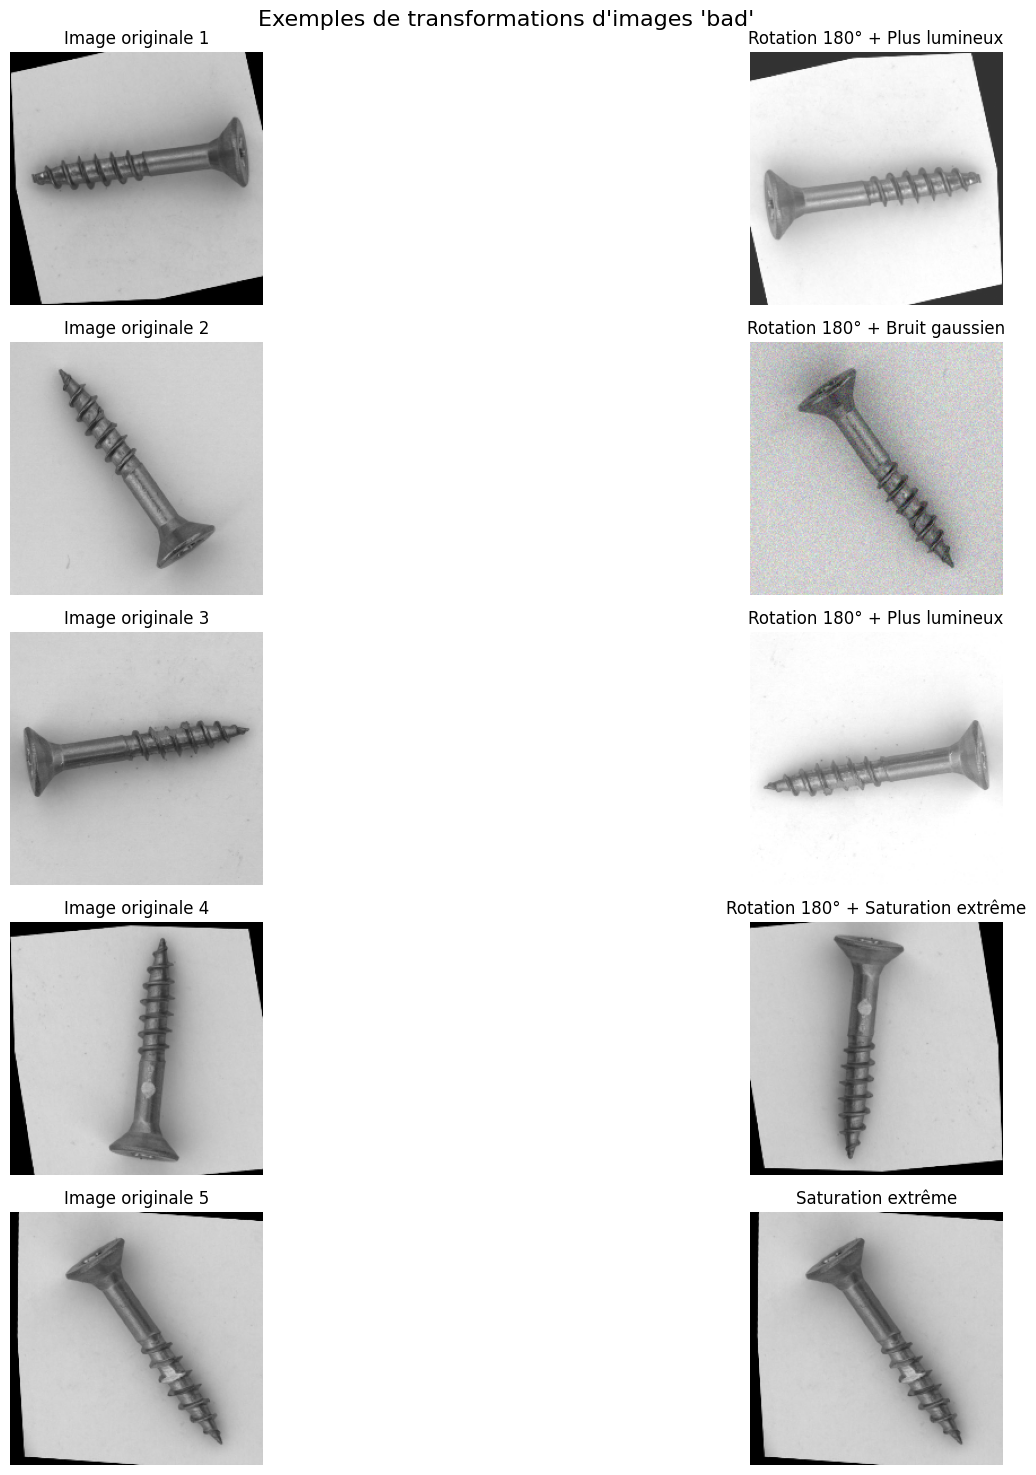

In [70]:
# Visualiser les augmentations
plt.figure(figsize=(20, 15))
visualization_samples = list(zip(X_bad[:5], X_bad_augmented[:5], used_transforms[:5]))

for i, (original, transformed, transform_type) in enumerate(visualization_samples):
    # Image originale
    plt.subplot(5, 2, i*2+1)
    plt.imshow(original)
    plt.title(f"Image originale {i+1}")
    plt.axis('off')
    
    # Image transformée
    plt.subplot(5, 2, i*2+2)
    plt.imshow(transformed)
    plt.title(transform_type)
    plt.axis('off')

plt.suptitle("Exemples de transformations d'images 'bad'", fontsize=16)
plt.tight_layout()
plt.savefig('augmented_bad_images.png')
plt.show()

# Modèle retravaillé

## 1. Définition du modèle CNN retravaillé

### Améliorations principales :

- binary_crossentropy pour la perte

- sigmoid pour la sortie binaire

- Plus de couches convolutives

- Batch Normalization pour stabiliser l'apprentissage

- Dropout pour réduire le surapprentissage

- Métriques supplémentaires (précision, recall, AUC)


(Note : Convolutional Neural Network (CNN), ou réseau de neurones convolutif en français, est une architecture spécifique de réseaux de neurones profonds utilisée en apprentissage automatique et notamment en Deep Learning.)

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    
    layers.Dense(1, activation='sigmoid')
])

# Pondération des classes
class_weights = {0: 5.0, 1: 1.0}  # Donner plus de poids aux "bad"

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

/Users/emmacoco/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 2. Callbacks

In [72]:
# Définition des callbacks
callbacks = [
    # Early Stopping: arrête l'entraînement si aucune amélioration n'est constatée
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    
    # ReduceLROnPlateau: réduit le taux d'apprentissage quand les métriques stagnent
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    ),
    
    # ModelCheckpoint: sauvegarde le meilleur modèle pendant l'entraînement
    tf.keras.callbacks.ModelCheckpoint(
        'best_screw_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

## 3. Entraînement du modèle

In [73]:


# Entraînement avec les poids de classe
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)

# Charger le meilleur modèle sauvegardé
model = tf.keras.models.load_model('best_screw_model.h5')

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.5639 - loss: 9.7943 - precision: 0.5920 - recall: 0.5444 - weighted_accuracy: 0.5683 - weighted_precision: 0.4940 - weighted_recall: 0.5444
Epoch 1: val_loss improved from inf to 5.48584, saving model to best_screw_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 436ms/step - accuracy: 0.5653 - loss: 9.7726 - precision: 0.5931 - recall: 0.5448 - weighted_accuracy: 0.5699 - weighted_precision: 0.4950 - weighted_recall: 0.5448 - val_accuracy: 0.2486 - val_loss: 5.4858 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_weighted_accuracy: 0.2486 - val_weighted_precision: 0.0000e+00 - val_weighted_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.6825 - loss: 6.9209 - precision: 0.7248 - recall: 0.5851 - weighted_accuracy: 0.7016 - weighted_precision: 0.6381 - weighted_recall: 0.5851
Epoch 2: val_loss did not improve from 5.48584
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 421ms/step - accuracy: 0.6821 - loss: 6.9156 - precision: 0.7240 - recall: 0.5852 - weighted_accuracy: 0.7010 - weighted_precision: 0.6371 - weighted_recall: 0.5852 - val_accuracy: 0.2486 - val_loss: 9.5686 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_weighted_accuracy: 0.2486 - val_

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 420ms/step - accuracy: 0.7364 - loss: 0.8739 - precision: 0.8753 - recall: 0.5593 - weighted_accuracy: 0.7723 - weighted_precision: 0.8250 - weighted_recall: 0.5593 - val_accuracy: 0.4277 - val_loss: 1.3580 - val_precision: 0.7313 - val_recall: 0.3769 - val_weighted_accuracy: 0.4277 - val_weighted_precision: 0.7313 - val_weighted_recall: 0.3769 - learning_rate: 5.0000e-04
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7153 - loss: 0.7608 - precision: 0.8350 - recall: 0.5563 - weighted_accuracy: 0.7482 - weighted_precision: 0.7718 - weighted_recall: 0.5563
Epoch 11: val_loss did not improve from 1.35799
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 426ms/step - accuracy: 0.7163 - loss: 0.7584 - precision: 0.8357 - recall: 0.5576 - weighted_accuracy: 0.7491 - weighted_precision: 0.7726 - weighted_recall: 0.5576 - val_accuracy: 0.3179 - val_loss: 1.6326 - val_precision: 0.8333 - val_recall: 0.1154 - val_weighted_accuracy: 0.3179 - val_weighted_precision

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 424ms/step - accuracy: 0.8360 - loss: 0.5318 - precision: 0.8028 - recall: 0.8890 - weighted_accuracy: 0.8255 - weighted_precision: 0.7310 - weighted_recall: 0.8890 - val_accuracy: 0.5318 - val_loss: 1.1727 - val_precision: 0.7634 - val_recall: 0.5462 - val_weighted_accuracy: 0.5318 - val_weighted_precision: 0.7634 - val_weighted_recall: 0.5462 - learning_rate: 5.0000e-04
Epoch 15/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8344 - loss: 0.4658 - precision: 0.8112 - recall: 0.8766 - weighted_accuracy: 0.8259 - weighted_precision: 0.7413 - weighted_recall: 0.8766
Epoch 15: val_loss did not improve from 1.17267
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 424ms/step - accuracy: 0.8342 - loss: 0.4663 - precision: 0.8107 - recall: 0.8768 - weighted_accuracy: 0.8256 - weighted_precision: 0.7407 - weighted_recall: 0.8768 - val_accuracy: 0.3468 - val_loss: 1.3749 - val_precision: 0.7576 - val_recall: 0.1923 - val_weighted_accuracy: 0.3468 - val_weighted_precision

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 422ms/step - accuracy: 0.8627 - loss: 0.5025 - precision: 0.8332 - recall: 0.9075 - weighted_accuracy: 0.8540 - weighted_precision: 0.7702 - weighted_recall: 0.9075 - val_accuracy: 0.4913 - val_loss: 0.9486 - val_precision: 0.7838 - val_recall: 0.4462 - val_weighted_accuracy: 0.4913 - val_weighted_precision: 0.7838 - val_weighted_recall: 0.4462 - learning_rate: 5.0000e-04
Epoch 17/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8431 - loss: 0.6405 - precision: 0.8090 - recall: 0.8975 - weighted_accuracy: 0.8322 - weighted_precision: 0.7386 - weighted_recall: 0.8975
Epoch 17: val_loss improved from 0.94861 to 0.82367, saving model to best_screw_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 422ms/step - accuracy: 0.8428 - loss: 0.6388 - precision: 0.8088 - recall: 0.8969 - weighted_accuracy: 0.8319 - weighted_precision: 0.7383 - weighted_recall: 0.8969 - val_accuracy: 0.6994 - val_loss: 0.8237 - val_precision: 0.7600 - val_recall: 0.8769 - val_weighted_accuracy: 0.6994 - val_weighted_precision: 0.7600 - val_weighted_recall: 0.8769 - learning_rate: 5.0000e-04
Epoch 18/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8110 - loss: 0.4921 - precision: 0.7370 - recall: 0.9036 - weighted_accuracy: 0.7945 - weighted_precision: 0.6519 - weighted_recall: 0.9036
Epoch 18: val_loss did not improve from 0.82367
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 424ms/step - accuracy: 0.8114 - loss: 0.4919 - precision: 0.7382 - recall: 0.9034 - weighted_accuracy: 0.7950 - weighted_precision: 0.6534 - weighted_recall: 0.9034 - val_accuracy: 0.4509 - val_loss: 8.1667 - val_precision: 0.8431 - val_recall: 0.3308 - val_weighted_accuracy: 0.4509 - val_weighted_precision

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 430ms/step - accuracy: 0.8989 - loss: 0.3585 - precision: 0.8725 - recall: 0.9332 - weighted_accuracy: 0.8920 - weighted_precision: 0.8204 - weighted_recall: 0.9332 - val_accuracy: 0.7225 - val_loss: 0.8086 - val_precision: 0.7662 - val_recall: 0.9077 - val_weighted_accuracy: 0.7225 - val_weighted_precision: 0.7662 - val_weighted_recall: 0.9077 - learning_rate: 5.0000e-04
Epoch 25/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8734 - loss: 0.3837 - precision: 0.8366 - recall: 0.9360 - weighted_accuracy: 0.8604 - weighted_precision: 0.7734 - weighted_recall: 0.9360
Epoch 25: val_loss did not improve from 0.80855
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 427ms/step - accuracy: 0.8734 - loss: 0.3831 - precision: 0.8366 - recall: 0.9359 - weighted_accuracy: 0.8605 - weighted_precision: 0.7734 - weighted_recall: 0.9359 - val_accuracy: 0.7572 - val_loss: 1.0667 - val_precision: 0.7619 - val_recall: 0.9846 - val_weighted_accuracy: 0.7572 - val_weighted_precision

## 4. Visualisations

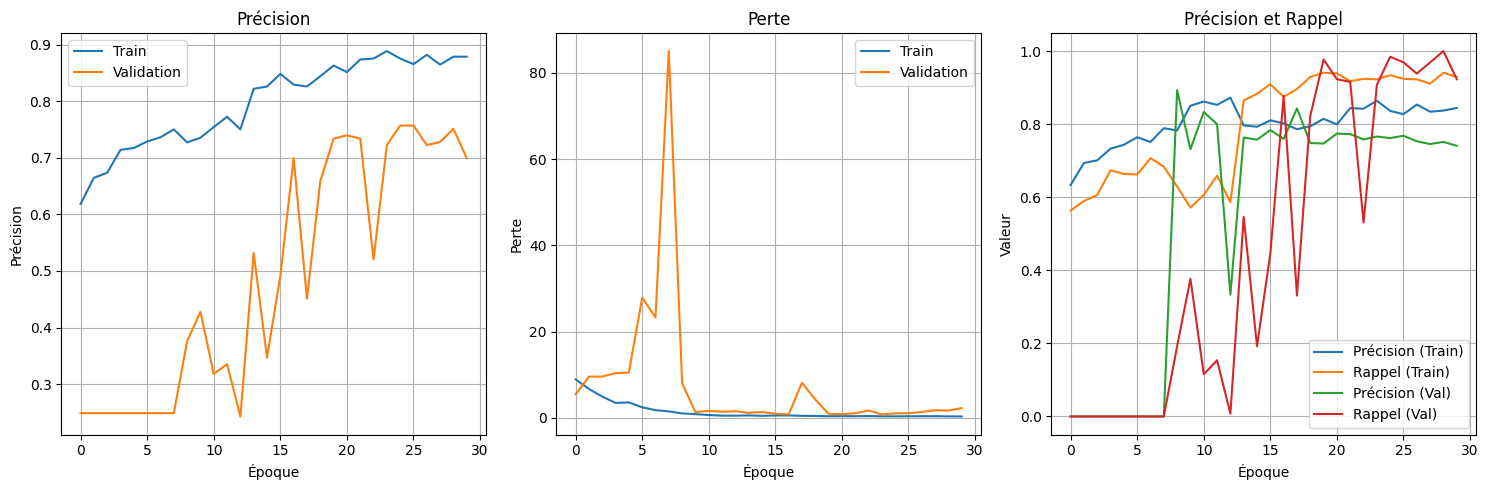

In [74]:
# Visualisation des courbes d'apprentissage
plt.figure(figsize=(15, 5))

# Graphique de l'accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

# Graphique de la perte
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

# Graphique de precision et recall
plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Précision (Train)')
plt.plot(history.history['recall'], label='Rappel (Train)')
plt.plot(history.history['val_precision'], label='Précision (Val)')
plt.plot(history.history['val_recall'], label='Rappel (Val)')
plt.title('Précision et Rappel')
plt.xlabel('Époque')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('courbes_apprentissage.png')
plt.show()

## 5. Évaluation sur l'ensemble de test

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7159 - loss: 1.0238 - precision_10: 0.7587 - precision_11: 0.7587 - recall_10: 0.9158 - recall_11: 0.9158 - weighted_accuracy: 0.7159

Résultats sur l'ensemble de test:
loss: 0.9565
compile_metrics: 0.7168
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


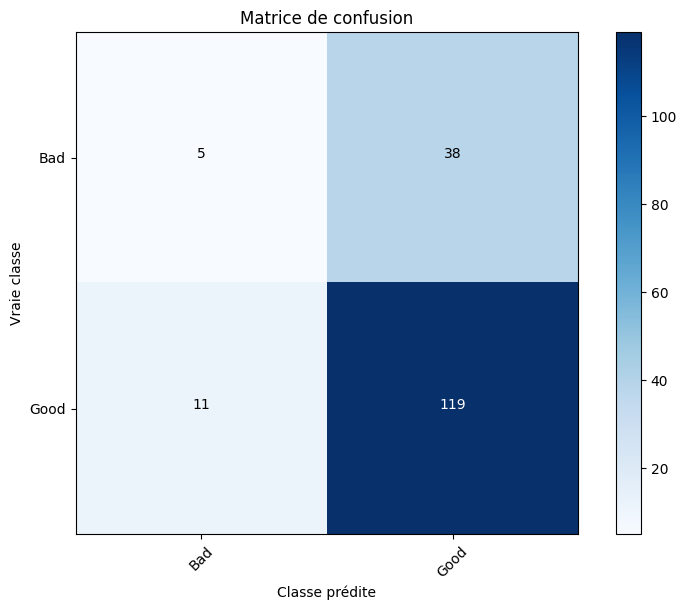


Rapport de classification:
              precision    recall  f1-score   support

         Bad       0.31      0.12      0.17        43
        Good       0.76      0.92      0.83       130

    accuracy                           0.72       173
   macro avg       0.54      0.52      0.50       173
weighted avg       0.65      0.72      0.67       173



In [75]:
# Évaluation sur l'ensemble de test
test_results = model.evaluate(test_dataset, verbose=1)
print("\nRésultats sur l'ensemble de test:")
for name, value in zip(model.metrics_names, test_results):
    print(f"{name}: {value:.4f}")

# Prédictions sur l'ensemble de test
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype(int)

# Obtenir les vraies étiquettes
y_true = []
for _, labels in test_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Matrice de confusion
def plot_confusion_matrix(cm, classes, normalize=False, title='Matrice de confusion', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    return plt

cm = confusion_matrix(y_true, y_pred_classes)
class_names = ['Bad', 'Good']  # 0 = Bad, 1 = Good
plot_confusion_matrix(cm, classes=class_names, title='Matrice de confusion')
plt.savefig('matrice_confusion.png')
plt.show()

# Rapport de classification
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nRapport de classification:")
print(report)

## Visualisation des données mal classifiées

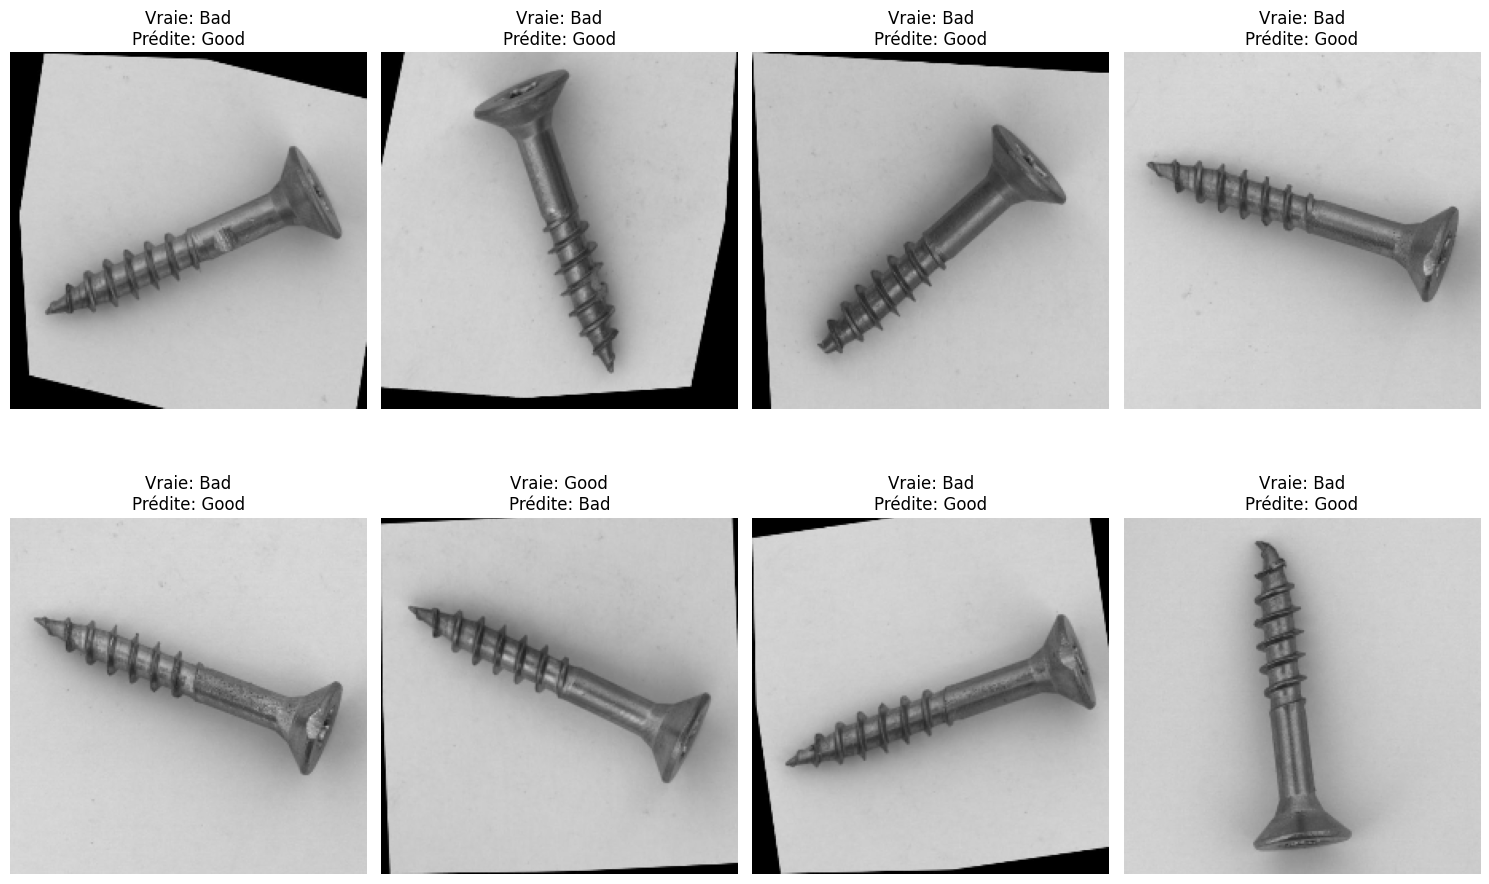


Nombre total d'exemples mal classés: 49 sur 173 (28.3%)


In [76]:
# Visualiser quelques exemples mal classés
misclassified_indices = []

# Collecter les indices des exemples mal classés
y_pred_flat = y_pred.flatten()
current_idx = 0

for x_batch, y_batch in test_dataset:
    y_batch_np = y_batch.numpy().flatten()
    pred_batch = (y_pred_flat[current_idx:current_idx+len(y_batch_np)] > 0.5).astype(int)
    
    for i in range(len(y_batch_np)):
        if pred_batch[i] != y_batch_np[i]:
            misclassified_indices.append((current_idx + i, x_batch[i].numpy(), 
                                          y_batch_np[i], pred_batch[i]))
    
    current_idx += len(y_batch_np)

# Afficher quelques exemples mal classés
plt.figure(figsize=(15, 10))
num_examples = min(8, len(misclassified_indices))

for i in range(num_examples):
    idx, img, true_label, pred_label = misclassified_indices[i]
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"Vraie: {class_names[int(true_label)]}\nPrédite: {class_names[int(pred_label)]}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('exemples_mal_classes.png')
plt.show()

print(f"\nNombre total d'exemples mal classés: {len(misclassified_indices)} sur {len(y_true)} ({len(misclassified_indices)/len(y_true)*100:.1f}%)")